# Importing Required Packages

In [ ]:
import os                   # for OS interactions 
import wget                 # for file downloading from the internet
import torch                # PyTorch library
import time                 # time-related funtions
import datetime             # date and time manipulation
import random               # random number generation
import pandas as pd         # data manipulation and analysis
import numpy as np          # for numerical computation
import tensorflow as tf     # TensorFlow library
from transformers import BertTokenizer                     # Hugging face's Transformers library
from torch.utils.data import TensorDataset, random_split   # PyTorch dataset utilities
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler   # PyTorch data loading utilities
from transformers import BertForSequenceClassification, AdamW, BertConfig   # components of BERT model and its configuration
from transformers import get_linear_schedule_with_warmup                    # Learning rate scheduler for BERT
from sklearn.metrics import matthews_corrcoef                               # metric for binary classification from scikit-learn

import matplotlib.pyplot as plt      # Plotting library for Python
%matplotlib inline
import seaborn as sns                # data visualizationn library

import warnings
warnings.filterwarnings('ignore')

# Setup

## Using GPU for training


To utilize the GPU with PyTorch, we first identify and designate the GPU as the device. Subsequently, during our training loop, we transfer data onto this device for processing

In [4]:
# if there is GPu available...
if torch.cuda.is_available():
  # tell PyTorch to use GPU
  device_name = torch.device('cuda')

  print('There are %d GPU(s) available' % torch.cuda.device_count())

  print('we will use the GPU : ', torch.cuda.get_device_name(0))

# if not...
else:
  print('No GPU available, using the CPU instead')
  device_name = torch.device('cpu')

There are 2 GPU(s) available
we will use the GPU :  Tesla T4


# Loading the CoLA Dataset


We will utilize [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification, which comprises sentences labeled as either grammatically correct or incorrect. CoLA was initially released in May 2018 and serves as one of the evaluation benchmarks in the GLUE Benchmark suite.

## Download and Extract


We will employ the wget package to fetch the dataset and store it in the respective file system.

In [6]:
print('Downloading the dataset...')

# URL for dataset zip file
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# download the file (if we haven't already)
if not os.path.exists('cola.zip'):
  wget.download(url, 'cola.zip')


Extract the dataset into the file system.

In [7]:
# unzip the dataset (if we haven't already)
if not os.path.exists('cola_public/'):
  !unzip cola.zip

## Parse


Both the tokenized and raw versions of the data are present in the file names. However, we cannot utilize the pre-tokenized version because when applying the pre-trained BERT model, we are required to use the tokenizer provided by the model. This is essential due to the model's specific vocabulary and the BERT tokenizer's unique method of handling out-of-vocabulary words. 

Using pandas, we will parse the "in-domain" training set and examine some of its characteristics and data points.

In [8]:
# load the dataset into pandas dataframe
df = pd.read_csv('./cola_public/raw/in_domain_train.tsv',
                 delimiter='\t',
                 header = None,
                 names = ['sentence_source', 'label', 'label_notes', 'sentence']
                 )

# report the number of sentences
print('Number of sentences {:,}'.format(df.shape[0]))

Number of sentences 8,551


In [9]:
# display first 5 rows from the data
df.head(5)

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


We focus on two properties: the `sentence` and its `label`, termed as 0 for unacceptable, and 1 for acceptable. Presented are five sentences labeled as grammatically unacceptable

In [10]:
df.loc[df.label == 0].head(5)[['sentence', 'label']]

,sentence,label
18,They drank the pub.,0
20,The professor talked us.,0
22,We yelled ourselves.,0
23,We yelled Harry hoarse.,0
25,Harry coughed himself.,0


We will extract the sentences and labels from our training set and convert them into numpy ndarrays.

In [11]:
# get the set of sentences and their respective labels
sentences = df.sentence.values
labels = df.label.values

# Tokenization and Input Formatting

## BERT Tokenizer

This code snippet downloads the BERT tokenizer, which is necessary for tokenizing text. The text needs to be split into tokens and then mapped to their corresponding indices in the tokenizer's vocabulary. We will use the `uncased` version of the tokenizer for this task.

In [12]:
# Load the BERT tokenizer...
print('Loading the BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(
                                'bert-base-uncased',
                                do_lower_case=True
                                )

Loading the BERT tokenizer...


Let's tokenize a single sentence to observe the output.

In [13]:
# print the original sentence
print('original sentence : ', sentences[0])

# print the sentence split into tokens
print('Tokenized : ', tokenizer.tokenize(sentences[0]))

# print the sentence mapped to token IDs
print('Token IDs : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

original sentence :  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized :  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs :  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


## Tokenize Dataset


This code snippet conducts a single tokenization pass over the dataset to determine the maximum length of sentences, which will be used for padding or truncation during encoding.

In [14]:
max_len = 0

# for every sentence
for sentence in sentences:

  # tokenize the text and add [CLS] and [SEP] tokens
  input_ids = tokenizer.encode(sentence, add_special_tokens=True)

  # update the maximum sentence length
  max_len = max(max_len, len(input_ids))

print('Maximum sentence length : ', max_len)

Maximum sentence length :  47



We are ready to tokenize our data using `tokenizer.encode_plus`, which handles several tasks:

1. It tokenizes the sentences.
2. Special tokens like `[CLS]` and `[SEP]` are added.
3. Token IDs are assigned to each token.
4. Sentences are padded or truncated to ensure uniform length.
5. Attention masks are created to differentiate real tokens from padding tokens.

While `tokenizer.encode` handles the first four tasks, we opt for `tokenizer.encode_plus` to also generate attention masks.

In [15]:
# tokenize all sentences and map tokens to their token IDs
input_ids = []
attention_masks = []

# for every sentence
for sentence in sentences:

  # This will:
  # 1) tokenize the sentence
  # 2) preprend [CLS] token to the start
  # 3) append [SEP] token to the end
  # 4) map token to their IDs
  # 5) pad or truncate sentence to max_length
  # 6) create attention masks for [PAD] tokens
  encoded_dict = tokenizer.encode_plus(
                          sentence,                     # sentence to encode
                          add_special_tokens=True,      # add [CLS] and [SEP] tokens
                          max_length = 64,              # pad and truncate all sentences
                          pad_to_max_length = True,
                          return_attention_mask = True, # construct attention masks
                          return_tensors = 'pt'         # return pytorch tensors
                        )

  # add encoded sentence to the list
  input_ids.append(encoded_dict['input_ids'])

  # and its attention mask
  attention_masks.append(encoded_dict['attention_mask'])

# convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [16]:
# print sample sentence, now as list of IDs
print('original sentence : ', sentences[0])
print('Token IDs : ', input_ids[0])

original sentence :  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs :  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## Training and Validation Split

Now, split the training set into 90% for training and 10% for validation.

In [17]:
# combine training inputs into TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# create 90-10 train-validation split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# divide dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:,} training samples'.format(train_size))
print('{:,} validation samples'.format(val_size))

7,695 training samples
856 validation samples



We will utilize the `torch DataLoader` class to create an iterator for our dataset. This approach conserves memory during training since, unlike a for loop, an iterator doesn't require loading the entire dataset into memory at once.

In [18]:
# batch size
batch_size = 32

# create DataLoaders for training and validation sets
# we will take training sample in random order
train_dataloader = DataLoader(
                      train_dataset,                          # training samples
                      sampler = RandomSampler(train_dataset), # select batches randomly
                      batch_size = batch_size                 # trains with this batch size
                  )

# for validation, the order doesn't matter, so we will read them sequetially
val_dataloader = DataLoader(
                      val_dataset,                               # validation samples
                      sampler = SequentialSampler(val_dataset),  # select batches sequentially
                      batch_size = batch_size                    # evaluate with this batch size
                  )

# Train our Classification Model

## BERT for sequence classification

We are going to customize a pre-trained BERT model for classification tasks. Specifically, we will employ the [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) interface provided by the Hugging Face library. This interface extends the basic BERT model by adding a classification layer on top. 

By fine-tuning this model on our dataset, we will optimize both the pre-trained BERT layers and the additional classification layer for our specific classification task.

In [19]:
# load the BertForSequenceClassification, pre-trained BERT mode with single linear classification layer

model = BertForSequenceClassification.from_pretrained(
                      'bert-base-uncased',          # use BERT base model (includes 12 layes), with uncased vocab
                      num_labels = 2,               # number of output labels = 2, for binary classification
                      output_attentions = False,    # whether model returns attention weights
                      output_hidden_states = False  # whether model returns hidden states
                  )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the following cell, I have displayed the names and sizes of the parameters for:

1. The embedding layer.
2. The first transformer among the twelve.
3. The output layer.

In [20]:
# get all of model's parameters as list of tuples
params = list(model.named_parameters())

print('BERT model has {:} different named parameters \n'.format(len(params)))

print('------------------------ Embedding Layer ------------------------\n')

for p in params[0:5]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n------------------------ First Transformer ------------------------\n')

for p in params[5:21]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n------------------------ Output Layer ------------------------\n')

for p in params[-4:]:
  print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

BERT model has 201 different named parameters 

------------------------ Embedding Layer ------------------------

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

------------------------ First Transformer ------------------------

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight      

## Optimizer and Learning Rate Scheduler

We need to extract the training hyperparameters from the pre-trained model. Based on the recommendations in the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf), we will select values for:

* Batch size: Choosing from `16` or `32`.
* Learning rate (Adam): Selecting from `5e-5`, `3e-5`, or `2e-5`.
* Number of epochs: Deciding among `2`, `3`, or `4`.

We have decided on:

* **Batch size**: `32` (specified during DataLoader creation).
* **Learning rate**: `2e-5`.
* **Epochs**: `4`

The epsilon parameter, `eps = 1e-8`, is set as a tiny value to prevent division by zero during optimization.

In [21]:
# AdamW is class from huggingface library (as opposed to pytorch)

optimizer = AdamW(
              model.parameters(),
              lr = 2e-5,          # learning rate - default is 5e-5, we have defined as 2e-5
              eps = 1e-8          # adam_epsilon - default is 1e-8
          )

In [22]:
# number of learning epochs
epochs = 4

# total number of training steps is [number of epochs] * [number of eopochs]
total_steps = len(train_dataloader) * epochs

# create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
                                        optimizer,
                                        num_warmup_steps = 0,
                                        num_training_steps=total_steps
                                    )

## Training Loop

This training loop consists of two main phases: training and validation.

**Training Phase**:

* Extract input data and labels.
* Transfer data to the GPU for faster processing.
* Clear previous gradients to avoid accumulation.
* Perform forward pass through the network.
* Conduct backward pass (backpropagation).
* Update network parameters using optimizer.step().
* Keep track of variables for monitoring progress.

**Validation Phase**:

* Extract input data and labels.
* Transfer data to the GPU.
* Perform forward pass through the network.
* Calculate loss on validation data and monitor progress.

Let's define a utility function to compute accuracy

In [23]:
# function to calculate accuracy of our predictions vs labels
def accuracy_flat(preds, labels):
  pred_flat = np.argmax(preds, axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

Function to format elapsed times as `hh:mm:ss`.

In [24]:
def format_time(elapsed):
  '''
  Takes time in seconds and returns in string format i.e. hh:mm:ss
  '''
  # round to nearest second
  elapsed_round = int(round(elapsed))

  # format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_round))

Ready for Training

In [25]:
# set the seed value
seed_val = 42
# Define the device 
device_name = torch.device("cuda:0")  

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# for storing training and validation loss, validation accuracy and timings
training_stats = []

# measure total training time for whole run
total_t0 = time.time()

# for each epoch...
for epoch in range(0, epochs):

  # ==================================================
  #                       Training
  # ==================================================

  print("")
  print('------------ Epoch {:} / {:} ------------'.format(epoch+1, epochs))
  print('training...')

  # for measuring how long each training epoch takes
  t0 = time.time()

  # reset total loss for this epoch
  total_train_loss = 0

  # put the model into training mode
  model.to(device_name)
  model.train()

  # for each batch of training data...
  for step, batch in enumerate(train_dataloader):

    # progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      # calculate elapsed time in minutes
      elapsed = format_time(time.time() - t0)

      # report progres
      print(' Batch {:>5,} of {:>5,}. Elapsed : {:}.'.format(step, len(train_dataloader), elapsed))

    # unpack training batch from dataloader
    batch_input_ids = batch[0].to(device_name)
    batch_input_mask = batch[1].to(device_name)
    batch_labels = batch[2].to(device_name)

    # clear any previously calculated gradients before performing backward pass
    model.zero_grad()

    # perform forward pass (evaluate model on this training batch)
    result = model(
                batch_input_ids,
                token_type_ids = None,
                attention_mask=batch_input_mask,
                labels = batch_labels,
                return_dict = True
              )

    # in the results, we get loss and logits i.e. the model outputs before activation
    loss = result.loss
    logits = result.logits

    # accumulate the training loss over all of batches
    total_train_loss += loss.item()

    # perform backward pass to calculate gradients
    loss.backward()

    # clip the norm of gradients to 1.0
    # that will help in preventing exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters and take step using computed gradient
    optimizer.step()

    # update the learning rate
    scheduler.step()

  # calculate average loss over all of batches
  avg_train_loss = total_train_loss / len(train_dataloader)

  # measure how long this epoch took
  training_time = format_time(time.time() - t0)

  print('')
  print('Average training loss : {0:.2f}'.format(avg_train_loss))
  print(' Training epoch took : {:}'.format(training_time))

  # ==================================================
  #                       Validation
  # ==================================================

  print("")
  print(' Running Validation...')

  t0 = time.time()

  # put the model in evaluation
  model.eval()

  # traking variables
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # evaluate data for one epoch
  for batch in val_dataloader:

    # unpack training batch from dataloader
    batch_input_ids = batch[0].to(device_name)
    batch_input_mask = batch[1].to(device_name)
    batch_labels = batch[2].to(device_name)

    # no need for constructing graph during forward pass, since this is only needed for backprop (training)
    with torch.no_grad():
      # forward pass, calculate logit predictions
      result = model(
                batch_input_ids,
                token_type_ids = None,
                attention_mask=batch_input_mask,
                labels = batch_labels,
                return_dict = True
              )

    # get the loss and logits output by model
    loss = result.loss
    logits = result.logits

    # accumulate the validation loss
    total_eval_loss += loss.item()

    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()

    # calculate accuracy for this batch of text sentences, and accumulate it over all batches
    total_eval_accuracy += accuracy_flat(logits, label_ids)

  # report the final accuracy for this validation run
  avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
  print("Accuracy : {0:.2f}".format(avg_val_accuracy))

  # calculate avg loss over all of batches
  avg_val_loss = total_eval_loss / len(val_dataloader)

  # measure how long validation run took
  val_time = format_time(time.time() - t0)

  print('Validation loss : {0:.2f}'.format(avg_val_loss))
  print(' Validation took : {:}'.format(val_time))

  # record all statistics from this epoch
  training_stats.append(
      {
          'epoch' : epoch + 1,
          'train loss' : avg_train_loss,
          'valid loss' : avg_val_loss,
          'valid accuracy' : avg_val_accuracy,
          'training time' : training_time,
          'validation time' : val_time
      }
  )

print('')
print('Training completed...')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))



------------ Epoch 1 / 4 ------------
training...
 Batch    40 of   241. Elapsed : 0:00:13.
 Batch    80 of   241. Elapsed : 0:00:26.
 Batch   120 of   241. Elapsed : 0:00:40.
 Batch   160 of   241. Elapsed : 0:00:54.
 Batch   200 of   241. Elapsed : 0:01:07.
 Batch   240 of   241. Elapsed : 0:01:20.

Average training loss : 0.49
 Training epoch took : 0:01:21

 Running Validation...
Accuracy : 0.82
Validation loss : 0.41
 Validation took : 0:00:03

------------ Epoch 2 / 4 ------------
training...
 Batch    40 of   241. Elapsed : 0:00:13.
 Batch    80 of   241. Elapsed : 0:00:26.
 Batch   120 of   241. Elapsed : 0:00:40.
 Batch   160 of   241. Elapsed : 0:00:53.
 Batch   200 of   241. Elapsed : 0:01:07.
 Batch   240 of   241. Elapsed : 0:01:20.

Average training loss : 0.31
 Training epoch took : 0:01:20

 Running Validation...
Accuracy : 0.84
Validation loss : 0.39
 Validation took : 0:00:03

------------ Epoch 3 / 4 ------------
training...
 Batch    40 of   241. Elapsed : 0:00:13.

Let's examine the overview of the training procedure.

In [26]:
# display floats with two decimal places
# pd.set_option('precision', 2)

# Define the format for floating-point numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# create dataframe from our training statistics
df_stats = pd.DataFrame(data = training_stats)

# use epoch as row index
df_stats = df_stats.set_index('epoch')

# display the table
df_stats

,train loss,valid loss,valid accuracy,training time,validation time
epoch,,,,,
1,0.49,0.41,0.82,0:01:21,0:00:03
2,0.31,0.39,0.84,0:01:20,0:00:03
3,0.20,0.44,0.84,0:01:20,0:00:03
4,0.14,0.53,0.84,0:01:20,0:00:03


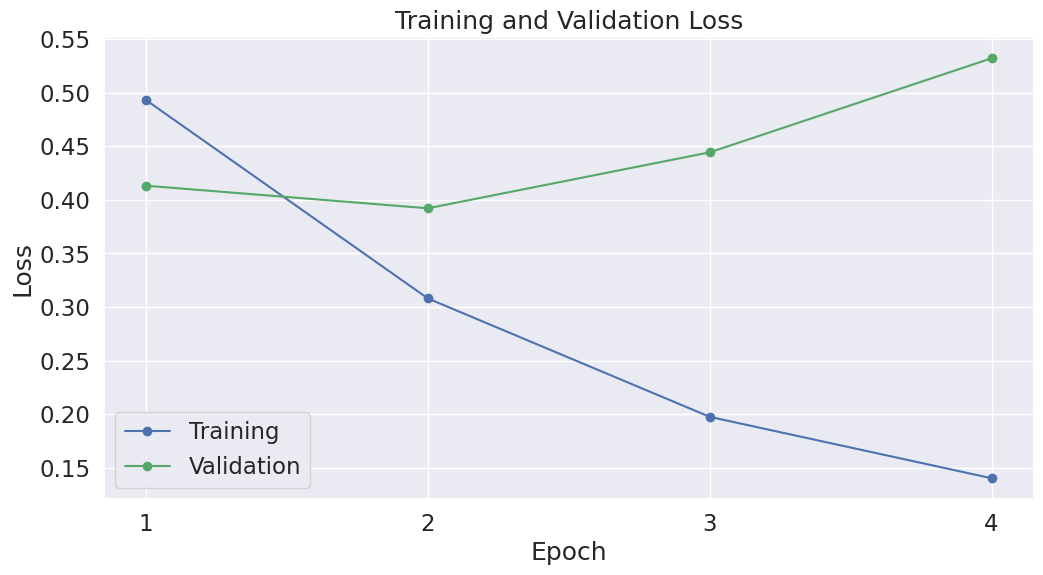

In [27]:
# use plot styling from seaborn
sns.set(style='darkgrid')

# increase plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# plot the learning curve
plt.plot(df_stats['train loss'], 'b-o', label="Training")
plt.plot(df_stats['valid loss'], 'g-o', label="Validation")

# label the plot
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Performance on Test Set

Now, we will load the holdout dataset and prepare inputs similar to what we did for the training set. Then, we will assess predictions using the [Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), a metric commonly used in the NLP community to evaluate performance on CoLA. This metric assigns a score between +1 (best) and -1 (worst), allowing us to compare our performance with state-of-the-art models for this task.

## Data Preparation

We will need to perform the same steps on the test dataset as we did for the training data to prepare it.

In [28]:
# load the dataset into pandas dataframe
df = pd.read_csv('./cola_public/raw/in_domain_dev.tsv',
                 delimiter='\t',
                 header = None,
                 names = ['sentence_source', 'label', 'label_notes', 'sentence']
                 )

# report the number of sentences
print('Number of sentences {:,}'.format(df.shape[0]))

# get the set of sentences and their respective labels
sentences = df.sentence.values
labels = df.label.values

Number of sentences 527


In [29]:
# tokenize all sentences and map tokens to their token IDs
input_ids = []
attention_masks = []

# for every sentence
for sentence in sentences:

  # This will:
  # 1) tokenize the sentence
  # 2) preprend [CLS] token to the start
  # 3) append [SEP] token to the end
  # 4) map token to their IDs
  # 5) pad or truncate sentence to max_length
  # 6) create attention masks for [PAD] tokens
  encoded_dict = tokenizer.encode_plus(
                          sentence,                     # sentence to encode
                          add_special_tokens=True,      # add [CLS] and [SEP] tokens
                          max_length = 64,              # pad and truncate all sentences
                          pad_to_max_length = True,
                          return_attention_mask = True, # construct attention masks
                          return_tensors = 'pt'         # return pytorch tensors
                        )

  # add encoded sentence to the list
  input_ids.append(encoded_dict['input_ids'])

  # and its attention mask
  attention_masks.append(encoded_dict['attention_mask'])

# convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [30]:
# set the batch size
batch_size = 32

# create the DataLoader
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(
                            prediction_data, 
                            sampler = prediction_sampler,
                            batch_size = batch_size
                            )

## Evaluate on Test Set

Now that the test set is ready, we can utilize our fine-tuned model to make predictions on this set.

In [31]:
# prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# put the model in evaluation mode
model.eval()

# tracking variables
predictions, true_labels = [], []

# predict
for batch in prediction_dataloader:
    # add batch to GPU
    batch = tuple(t.to(device_name) for t in batch)
    
    # unpack inputs from our dataloader
    batch_input_ids, batch_input_mask, batch_labels = batch
    
    # telling model not to compute or store gradients
    # for saving memory and speeding up prediction
    with torch.no_grad():
        # forward pass, calculate logit predictions
        result = model(
                    batch_input_ids,
                    token_type_ids = None,
                    attention_mask = batch_input_mask,
                    return_dict = True
                    )
        
    logits = result.logits
    
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = batch_labels.to('cpu').numpy()
    
    # store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
    
print('Done.')

Predicting labels for 527 test sentences...
Done.


In [32]:
print('Positive samples: %d of %d (%.2f%%)' % (
                                        df.label.sum(),
                                        len(df.label),
                                       (df.label.sum() / len(df.label)) * 100.0))

Positive samples: 365 of 527 (69.26%)


In [33]:
matthews_set = []

# evaluate each test batch using Matthew's correlation coefficient
print("Calculating Matthew's correlation coefficient for each batch...")

# for each input batch...
for batch in range(len(true_labels)):
    
    pred_labels = np.argmax(predictions[batch], axis = 1).flatten()
    
    # calculate and store coefficient for this batch
    matthews = matthews_corrcoef(true_labels[batch], pred_labels)
    matthews_set.append(matthews)

Calculating Matthew's correlation coefficient for each batch...


The overall score will be calculated using the entire test set. However, we will examine scores for individual batches to understand the variability in the metric across batches. Each batch contains 32 sentences, except for the last batch, which has only 4 test sentences.

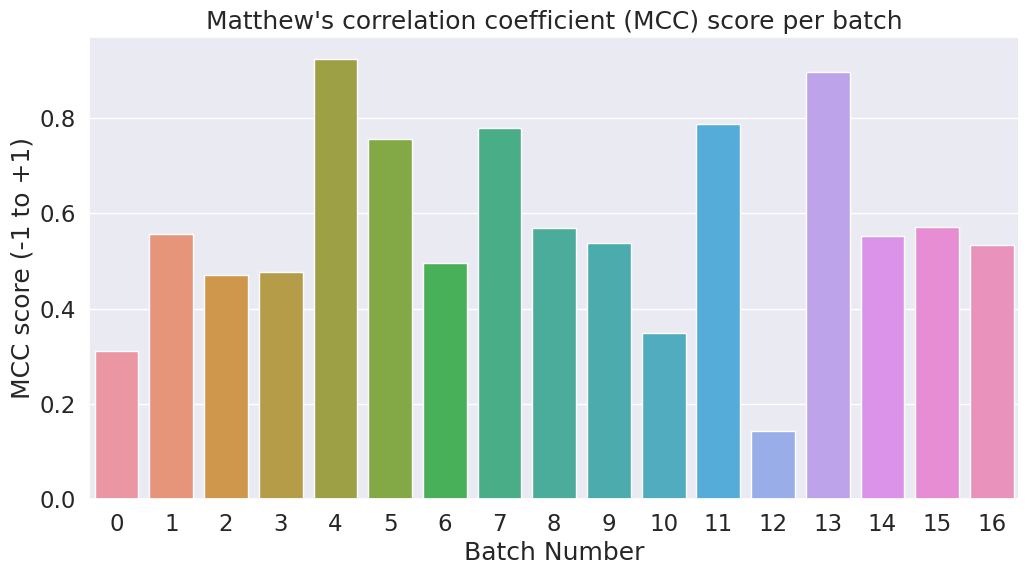

In [34]:
# create bar plot showing the Matthew's correlation coefficient (MCC) score for each batch of test samples
ax = sns.barplot(
            x = list(range(len(matthews_set))), 
            y = matthews_set,
            ci = None
        )

plt.title("Matthew's correlation coefficient (MCC) score per batch")
plt.ylabel('MCC score (-1 to +1)')
plt.xlabel('Batch Number')

plt.show()

Next, we will aggregate the results from all batches and compute our final MCC score.

In [35]:
# combine the results across all batches
flat_predictions = np.concatenate(predictions, axis=0)

# for each sample, pick the label (0 or 1) with the higher score
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# combine the correct labels for each batch into single list
flat_true_labels = np.concatenate(true_labels, axis=0)

# calculate total MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC : %.3f' % mcc)

Total MCC : 0.589


# Conclusion


This notebook illustrates how a pre-trained BERT model, when utilized through the PyTorch interface, enables the minimal and efficient creation of a high quality model with minimal training time, regardless of the particular NLP task at hand.